# Extension to many dimensions

MRA is straightforward and efficient in 1D.  Extension to multiple dimensions requires additional techniques for efficiency and good numerical conditioning:
* Adaptive local refinement
* Non-standard form of operators
* Separated representation of operators

In this section, we examine adaptive local refinement in 2 and higher dimensions, and the non-standard form.

## Wavelet transform in multiple dimensions and adaptive local refinement

Consider a 1D function $f(x)$ tabulated on a grid of points $x_i, i=1,\ldots,2^n$. If you are using multiwavelets, you could instead store the scaling function coefficients. Either way, this is just a vector ($f$) of numbers.  Compression (the wavelet transformation) is a linear transformation ($W$) so we can obtain the wavelet coefficients ($\bar{f}$) as follows
$$\bar{f} = W f$$

Now consider a 2D function $f(x,y)$ tablulated on a mesh formed from the tensor product of points $x_i, i=1,\ldots,2^n$ and $y_i, i=1,\ldots,2^n$.  The multi-wavelet scaling functions in multiple dimensions are just the tensor product of the 1D functions (e.g., in 2D $\phi^n_{i l_x} \phi^n_{j l_y}$).  So again, either way you just have a square matrix ($F$) of numbers.

To obtain the wavelet coefficients ($\bar{F}$) it is natural to apply the wavelet transformation separately in each dimension.
$$\bar{F} = W F W^T$$.

This is the so-called *standard form* and was employed in early attempts to employ multi-resolution analysis in solution of partial differential equations.  However, while it is intuitive, it leads to multiple problems
* adaptive local refinement is not possible since there are basis functions that are fine-scale in one dimension and coarse scale in another
* for the same reason the representation is numerically poorly conditioned
* computing this representation is expensive in memory and compute (since you need to store the entire function for the transformation to be completed).
In the figure below,$\phi^0_0$ labels the scaling function at level 0, and $\varphi^n_l$ labels the wavelets at level $n$ and translation $l$ in each dimension.  The red areas depict the support of each 2D basis function, and you can see that some functions are long thin rectangles indicating a coarse scale in one dimension and a fine scale in the other.
![standard form](standard_form.png "Standard Form")

To refine locally, we need to refine in all dimensions simultaneously. First we can do this for one level of refinement. In the figure below, $\phi(x)$ denotes the 1D scaling function (and $\varphi(x)$ the wavelet) at the coarsest scale $n=0$.  Hence, using translation and dilation, $\sqrt{2} \phi(2x)$ and $\sqrt{2} \phi(2x-1)$ are the scaling functions at level $n=1$.  $V_0$ and $V_1$ are the space of functions spanned by the scaling functions at levels $0$ and $1$, respectively. Finally, the space of wavelets at level $0$ is defined as $W_0 = V_1 - V_0$. 
![local1](local1.png "Local transformation for one level")

Next we just do this with local recursion.  The resulting basis spans exactly the same space as the standard form --- we've just performed an orthogonal transformation.  If you look at the red-boxes that label the support of the basis functions, you can see that each box is square as a result of each dimension being simultaneously refined.  
![local2](local2.png "Recursive local transformation for multiple levels")

Finally, adaptive local refinement is now possible by simply discarding boxes with small wavelet coefficients.


The following example displays the adapative numerical mesh for an exponential (Slater) function.

(<Figure size 900x900 with 1 Axes>, <Axes3DSubplot:>)

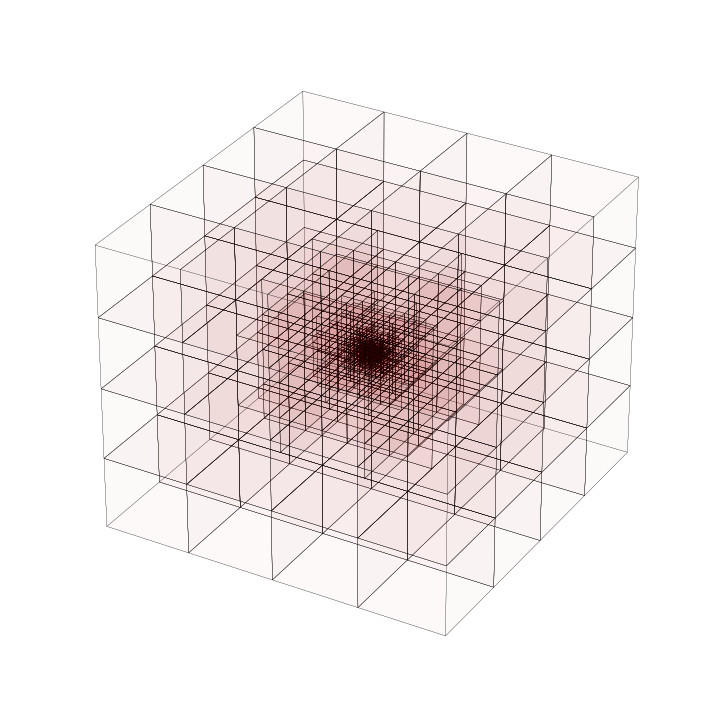

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from vampyr import vampyr3d as vp

# Import the grid plotter function from your plotter module
from plotter import grid_plotter

# Set up the multi resolution analysis with the specified box and order
MRA = vp.MultiResolutionAnalysis(box=[0, 1], order=3)

# Define the function to be used (in this case, a Slater function centered at 0.5)
def slater_function(x):
    r = np.linalg.norm(np.array(x) - 0.5)  # Calculate the distance from 0.5
    return np.exp(- 50.0 * np.abs(r))  # Return the Slater function value

# Project the function onto the MRA
P_eps = vp.ScalingProjector(MRA, 2*1.0e-2)
f_tree = P_eps(slater_function)

# Use the grid plotter to visualize the function tree
grid_plotter(f_tree)


## Non-standard form of operators

The non-standard form of operators was introduced (Gregory Beylkin, Vani Cheruvu, and Fernando Pérez, "Fast adaptive algorithms in the non-standard form for multidimensional problems," Appl. Comput. Harmon. Anal., 24, pp. 354–377, 2008) to address the disadvatages of the standard form.

Consider a linear operator ($T$) acting on a function $f(x)$ in 1 or more dimensions
$$ (T f)(x) = \int K(x,y) f(y) dy $$
You can see that even a "1D" operator involves a kernel $K(x,y)$ that is a 2D function.  Hence, all of the concerns we had above about representing functions beyond 1D reappear for operators.

Standard form of operators:
* Matrix elements between different length scales
* Not very efficient on modern computers with deep memory hierarchies
* Potentially O(Nlog N) non-zero terms even for operators smooth at long range
* Hard to calculate matrix elements, high-memory use

Non-standard form of operators:
* No matrix elements between lengths scales
* O(N) terms for operators smooth at long range
* Act on (modified) non-standard form of functions
* Easy to calculate matrix elements
* Translation invariant operators yield Topelitz matrices (i.e., only one unique block per super diagonal)


The derivation of the non-standard form is very instructive and starts with the telescoping series that is central to understanding multiresolution.

Let $V_n$ be the space of scaling functions at level $n$ of refinement.  For simplicity, this might just be function values tablulated on a mesh at level $n$ of refinement.  Consider now a ladder of such spaces with the property that each coarse mesh is exactly contained as a subset of finer meshes
$$V_0 \subset V_1 \subset \cdots \subset V_{n-1} \subset V_n$$
We can then write the telescoping series
$$V_n = V_0 + (V_1 - V_0) + \cdots + (V_n - V_{n-1})$$
which is the sum of space of functions at the coarsest level plus corrections at successive levels of refinement.

The space of wavelets at level $n$ is defined as $W_n = V_{n} - V_{n-1}$, which is the orthgonal complement of $V_{n-1}$ in $V_n$.  Thus, 
$$V_n = V_0 + \sum_{m=0}^{n-1} W_m$$
I.e., we have decomposed a function represented in $V_n$ as a sum of scaling functions at the coarsest level plus wavelets at levels.

Define $P_n$ to be a projector onto $V_n$ and $Q_n$ to be a projector onto $W_n$.  By the definition of $W_n$, we have $P_n = P_{n-1} + Q_{n-1}$.

The representation of an operator $T$ at level $n$ is 
$$T_n = P_n T P_n$$
This takes an function at level $n$, applies the operator, and projects the result back to level $n$.  

The derivation of the non-standard form proceeds as follows
$$
T_n = P_n T P_n \\
 = (P_{n-1} + Q_{n-1}) T (P_{n-1} + Q_{n-1}) \\
 = P_{n-1} T P_{n-1} + Q_{n-1} T Q_{n-1} + Q_{n-1} T P_{n-1} + P_{n-1} T Q_{n-1} \\
 = T_{n-1} + A_{n-1} + B_{n-1} + C_{n-1} \\
 = T_0 + \sum_{m=0}^{n-1} {(A_m + B_m + C_m)}
$$
Note that each operator acts and produces results on the same length scale.
* It is called the non-standard form because the input function needs to provide both scaling function coefficients and wavelet coefficients at all levels (which is redundant information --- normally we would only store scaling function coefficients at the coarsest level and wavelet coefficients at all levels).
* $A_m$ acts on wavelets at level $m$ and produces wavelets at the same level.  If $T$ is the Coulomb operator and you are using an order $k$ multiwavelet basis, then elements of $A_m$ decay as $r^{2k+1}$ (which you can see by considering the multipole expansion).
* $B_m$ acts on scaling functions at level $m$ and produces wavelets, and v.v. for $C_m$.  For the Coulomb operator their matrix elements decay as $r^{k+1}$. 
* Every block of each operator can be applied independently, hence there is massive parallelism.
* The result will also be produced in non-standard form.  Hence, after applying the operator, the scaling coefficients must be summed up the tree using a modified fast wavelet transform to restore the standard compressed representation of the result.

Finally, the non-standard form matrix elements are readily computed from matrix elements of the operator over the scaling function basis and the two-scale relationship.
